In [125]:
import pandas as pd
import numpy as np
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *

In [85]:
# getting data
corpus_df, val_corpus_df, emotion_df, val_emotion_df, valence_df, val_valence_df = get_labeled_dfs()


In [86]:
# using custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)


In [87]:
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,two hussein ally hang iraqi official say
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [88]:
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,label
0,0,0,15,38,9,11,joy,3
1,24,26,16,13,38,5,sadness,4
2,0,0,0,17,0,4,joy,3
3,0,0,0,46,0,31,joy,3
4,1,0,23,8,11,8,fear,2


## RNN: Emotion Labels

In [89]:
# create a set of unique words in the corpus
vocab = set()
for headline in corpus_df['text']:
    for word in headline.split():
        vocab.add(word)

# get vectors from the pretrained vocab and create a dictionary with the words from the set as keys
glove_embeddings = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for i in f:
        key_vec = i.split()
        word = key_vec[0].decode('utf-8')
        if word in vocab:
            glove_embeddings[word] = np.array(key_vec[1:], dtype=np.float32)

In [127]:
X = corpus_df['text']
y = emotion_df['label']

tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(X)
# add zeros to the front of each sequence as necessary to make them all the same length
padded_X = sequence.pad_sequences(sequences, maxlen=15)


In [128]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequecne numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in glove_embeddings.keys():
        embedding_matrix[ind + 1, :] = glove_embeddings[word]


In [129]:
random.seed(2)
train_list = np.random.choice(range(0,1000), size=750, replace=False)
test_list = [i for i in range(0,1000) if i not in train_list]

X_train = padded_X[train_list]
X_test = padded_X[test_list]


# labels one hot encoded
y_train = pd.get_dummies(y.iloc[train_list]).values
y_test = pd.get_dummies(y.iloc[test_list]).values

# y_train_binary = keras.utils.to_categorical(y_train, 6)
# y_test_binary = keras.utils.to_categorical(y_test, 6)


In [130]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,  183, 2114,
         74,   28,   82,  263], dtype=int32)

In [131]:
model = Sequential()

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=15, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=rmsprop(lr=.001, decay=.00001),
              metrics=['accuracy'])



history = model.fit(X_train, 
                    y_train,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_test, y_test))



Train on 750 samples, validate on 250 samples
Epoch 1/100
750/750 [==============================] - 3s 4ms/step - loss: 0.1707 - acc: 0.2013 - val_loss: 0.1364 - val_acc: 0.2840
Epoch 2/100
750/750 [==============================] - 1s 746us/step - loss: 0.1609 - acc: 0.2453 - val_loss: 0.1297 - val_acc: 0.3800
Epoch 3/100
750/750 [==============================] - 1s 706us/step - loss: 0.1430 - acc: 0.3293 - val_loss: 0.1262 - val_acc: 0.4360
Epoch 4/100
750/750 [==============================] - 1s 762us/step - loss: 0.1359 - acc: 0.3693 - val_loss: 0.1160 - val_acc: 0.4800
Epoch 5/100
750/750 [==============================] - 1s 783us/step - loss: 0.1282 - acc: 0.4053 - val_loss: 0.1119 - val_acc: 0.5120
Epoch 6/100
750/750 [==============================] - 1s 721us/step - loss: 0.1184 - acc: 0.4493 - val_loss: 0.1102 - val_acc: 0.5080
Epoch 7/100
750/750 [==============================] - 1s 957us/step - loss: 0.1141 - acc: 0.4827 - val_loss: 0.1104 - val_acc: 0.5120
Epoch 8/100

750/750 [==============================] - 1s 783us/step - loss: 0.0097 - acc: 0.9680 - val_loss: 0.1312 - val_acc: 0.5040
Epoch 62/100
750/750 [==============================] - 1s 1ms/step - loss: 0.0084 - acc: 0.9747 - val_loss: 0.1327 - val_acc: 0.5240
Epoch 63/100
750/750 [==============================] - 1s 810us/step - loss: 0.0100 - acc: 0.9640 - val_loss: 0.1342 - val_acc: 0.5120
Epoch 64/100
750/750 [==============================] - 1s 830us/step - loss: 0.0105 - acc: 0.9627 - val_loss: 0.1428 - val_acc: 0.5080
Epoch 65/100
750/750 [==============================] - 1s 1ms/step - loss: 0.0106 - acc: 0.9613 - val_loss: 0.1415 - val_acc: 0.4960
Epoch 66/100
750/750 [==============================] - 1s 962us/step - loss: 0.0105 - acc: 0.9573 - val_loss: 0.1412 - val_acc: 0.4800
Epoch 67/100
750/750 [==============================] - 1s 800us/step - loss: 0.0081 - acc: 0.9720 - val_loss: 0.1486 - val_acc: 0.4800
Epoch 68/100
750/750 [==============================] - 1s 799us/

In [132]:
model.evaluate(X_test, y_test)

250/250 [==============================] - 0s 315us/step


[0.1470446162223816, 0.48000000143051147]

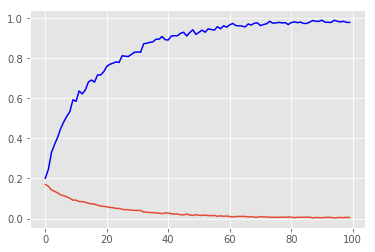

In [133]:
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')

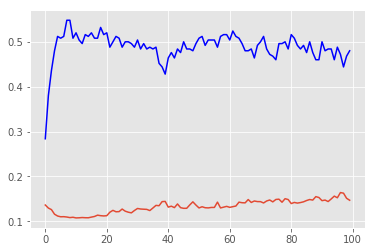

In [134]:
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')

In [135]:
preds = model.predict_on_batch(X_test)

emotion_preds = pd.DataFrame({"Prediction Anger":preds[:,0], "Prediction Disgust":preds[:,1], "Prediction Fear":preds[:,2], "Prediction Joy":preds[:,3], "Prediction Sadness":preds[:,4], "Prediction Surprise":preds[:,5], "Anger":y_test[:,0], "Disgust":y_test[:,1], "Fear": y_test[:,2], "Joy": y_test[:,3], "Sadness": y_test[:,4], "Surprise": y_test[:,5]})
emotion_preds.head()

,Prediction Anger,Prediction Disgust,Prediction Fear,Prediction Joy,Prediction Sadness,Prediction Surprise,Anger,Disgust,Fear,Joy,Sadness,Surprise
0,0.000015,1.169497e-04,0.000007,7.581752e-07,9.998347e-01,2.609282e-05,0,0,0,0,1,0
1,0.000151,3.676117e-04,0.000060,9.959201e-01,2.266528e-05,3.478254e-03,0,0,0,1,0,0
2,0.000284,2.363551e-04,0.000008,9.993095e-01,2.705152e-05,1.352940e-04,0,0,0,1,0,0
3,0.146934,4.318893e-02,0.069849,4.769717e-01,2.594205e-02,2.371147e-01,0,0,0,0,0,1
4,0.999998,1.241549e-07,0.000002,1.588356e-07,7.410843e-09,1.866935e-08,1,0,0,0,0,0


# RNN with Valence Labels

In [138]:
X = corpus_df['text']
y = valence_df['label']

tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X))
sequences = tokenizer.texts_to_sequences(X)
padded_X = sequence.pad_sequences(sequences, maxlen=15)


In [139]:
random.seed(2)
train_list = np.random.choice(range(0,1000), size=750, replace=False)
test_list = [i for i in range(0,1000) if i not in train_list]

X_train = padded_X[train_list]
X_test = padded_X[test_list]

# labels one hot encoded
y_train = (y.iloc[train_list]).values
y_test = (y.iloc[test_list]).values

y_train_binary = keras.utils.to_categorical(y_train, 3)
y_test_binary = keras.utils.to_categorical(y_test, 3)

X_train

model = Sequential()

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=15, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=rmsprop(lr=.001, decay=.00001),
              metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train_binary,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_test, y_test_binary))


Train on 750 samples, validate on 250 samples
Epoch 1/100
750/750 [==============================] - 4s 5ms/step - loss: 0.2857 - acc: 0.3667 - val_loss: 0.2105 - val_acc: 0.4920
Epoch 2/100
750/750 [==============================] - 1s 709us/step - loss: 0.2508 - acc: 0.4187 - val_loss: 0.2038 - val_acc: 0.4560
Epoch 3/100
750/750 [==============================] - 1s 771us/step - loss: 0.2268 - acc: 0.4893 - val_loss: 0.1844 - val_acc: 0.5760
Epoch 4/100
750/750 [==============================] - 1s 707us/step - loss: 0.2135 - acc: 0.5293 - val_loss: 0.1783 - val_acc: 0.6160
Epoch 5/100
750/750 [==============================] - 1s 682us/step - loss: 0.1971 - acc: 0.5493 - val_loss: 0.1757 - val_acc: 0.6040
Epoch 6/100
750/750 [==============================] - 1s 844us/step - loss: 0.1791 - acc: 0.6040 - val_loss: 0.1759 - val_acc: 0.5960
Epoch 7/100
750/750 [==============================] - 1s 746us/step - loss: 0.1706 - acc: 0.6280 - val_loss: 0.1761 - val_acc: 0.6200
Epoch 8/100

In [140]:
model.evaluate(X_test, y_test_binary)


250/250 [==============================] - 0s 321us/step


[0.25266193628311157, 0.5840000023841858]

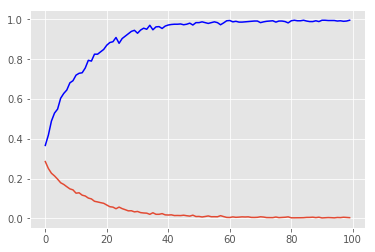

In [141]:
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')


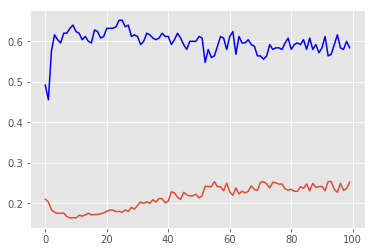

In [142]:
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')


In [143]:
preds = model.predict_on_batch(X_test)

In [144]:
valence_preds = pd.DataFrame({"Prediction Neg":preds[:,0], "Prediction Pos":preds[:,1], "Prediction Neu":preds[:,2], "Neg":y_test_binary[:,0], "Pos":y_test_binary[:,1], "Neu": y_test_binary[:,2]})
valence_preds.head()

,Prediction Neg,Prediction Pos,Prediction Neu,Neg,Pos,Neu
0,0.999642,0.000021,0.000337,0.0,1.0,0.0
1,0.999987,0.000002,0.000011,1.0,0.0,0.0
2,0.000535,0.001781,0.997684,1.0,0.0,0.0
3,0.000014,0.000004,0.999982,0.0,0.0,1.0
4,0.000093,0.999869,0.000038,0.0,0.0,1.0
